# **DeepLandforms**

Author: giacomo.nodjoumi@hyranet.info - g.nodjoumi@jacobs-university.de

## DeepLandforms Training

With this notebook, users can train instance segmentation models on custom dataset of georeferenced images.
The models are based on state-of-the-art general purpose architectures, available [here](https://github.com/facebookresearch/detectron2).
Despite several types of networks are supported, such as object detection, image segmentation ad instance segmentation, and available in the above repository, this notebook and the complementary **DeepLandrorms-Segmentation** notebook are specific for instance segmentation architectures for georefernced images.

## Usage

* Prepare the dataset in COCO label format, using provided **LabelMe** container or else.
* Put or link the dataset into the **DeepLandforms** *.env* file
* Run docker-compose up
* Edit the *configs* section by editing the following parameters:
------------------------------------------------------------------
| **Parameter** | **Function** | **Common Values** |
| ---- | ---- | ---- |
| **cfg.merge_from_file(model_zoo.get_config_file(""))** | Model Architecture | MASK-R-CNN in this work |
| **cfg.TEST.EVAL_PERIOD** |  N° of epochs after an evaluation is performed | depending on SOLVER.MAX_ITER, usually every 1/10 of ITER, e.g. every 1000 on a 10000 iter |
| **cfg.DATALOADER.NUM_WORKERS** | Number of workers for dataloader | usually correspond to cpu cores |
| **cfg.MODEL.WEIGHTS** | model_zoo.get_checkpoint_url("") | Optional but advised to start from a pretrained model from the model zoo, MUST be of the same architecture of the get_config_file. see default values as example. |
| **cfg.SOLVER.IMS_PER_BATCH** | How many image to be ingested, depends on the performance of the GPU, especiall VRAM |  up to 8 for 8GB VRAM |
| **cfg.SOLVER.BASE_LR** | learning rate | 0.0002 is a good starting point |
| **cfg.SOLVER.MAX_ITER** | N° of epochs | Rise up for low mAP, lower to prevent overfitting |
| **cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE** | parameter to sample a subset of proposals coming out of RPN to calculate cls and reg loss during training. | multiple of 2, commonly 64 |
------------------------------------------------------------------
Then just execute the notebook and monitor the training in **Tensorboard** container.

## Funding
*This study is within the Europlanet 2024 RI and EXPLORE project, and it has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement No 871149 and No 101004214.*

------------------------------------------------------------------

In [1]:
import cv2
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
%matplotlib inline
from matplotlib import pyplot as plt
import os
import random
import torch
from utils.detectron_utils import Trainer
from utils.train_utils import categories_gen, classes_distribution, dataframes_gen, dataMover, datasetReg
from detectron2.evaluation import COCOEvaluator

In [2]:
dataset, meta, classes , train_dir, image_path = datasetReg()

In [3]:
train_df_dis, valid_df_dis, test_df_dis, train, valid, test = dataframes_gen(classes, dataset)

**CONFIGS - edit befor run**

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('train_data',)
cfg.DATASETS.TEST = ('valid_data',)
cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.002 
cfg.SOLVER.MAX_ITER = 5000 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE =  128 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)  
cfg.OUTPUT_DIR = train_dir

**End of configs**

In [5]:
dataMover(image_path, train, valid, test)

Text(0.5, 1.0, 'Test Dataset\n55 Labels')

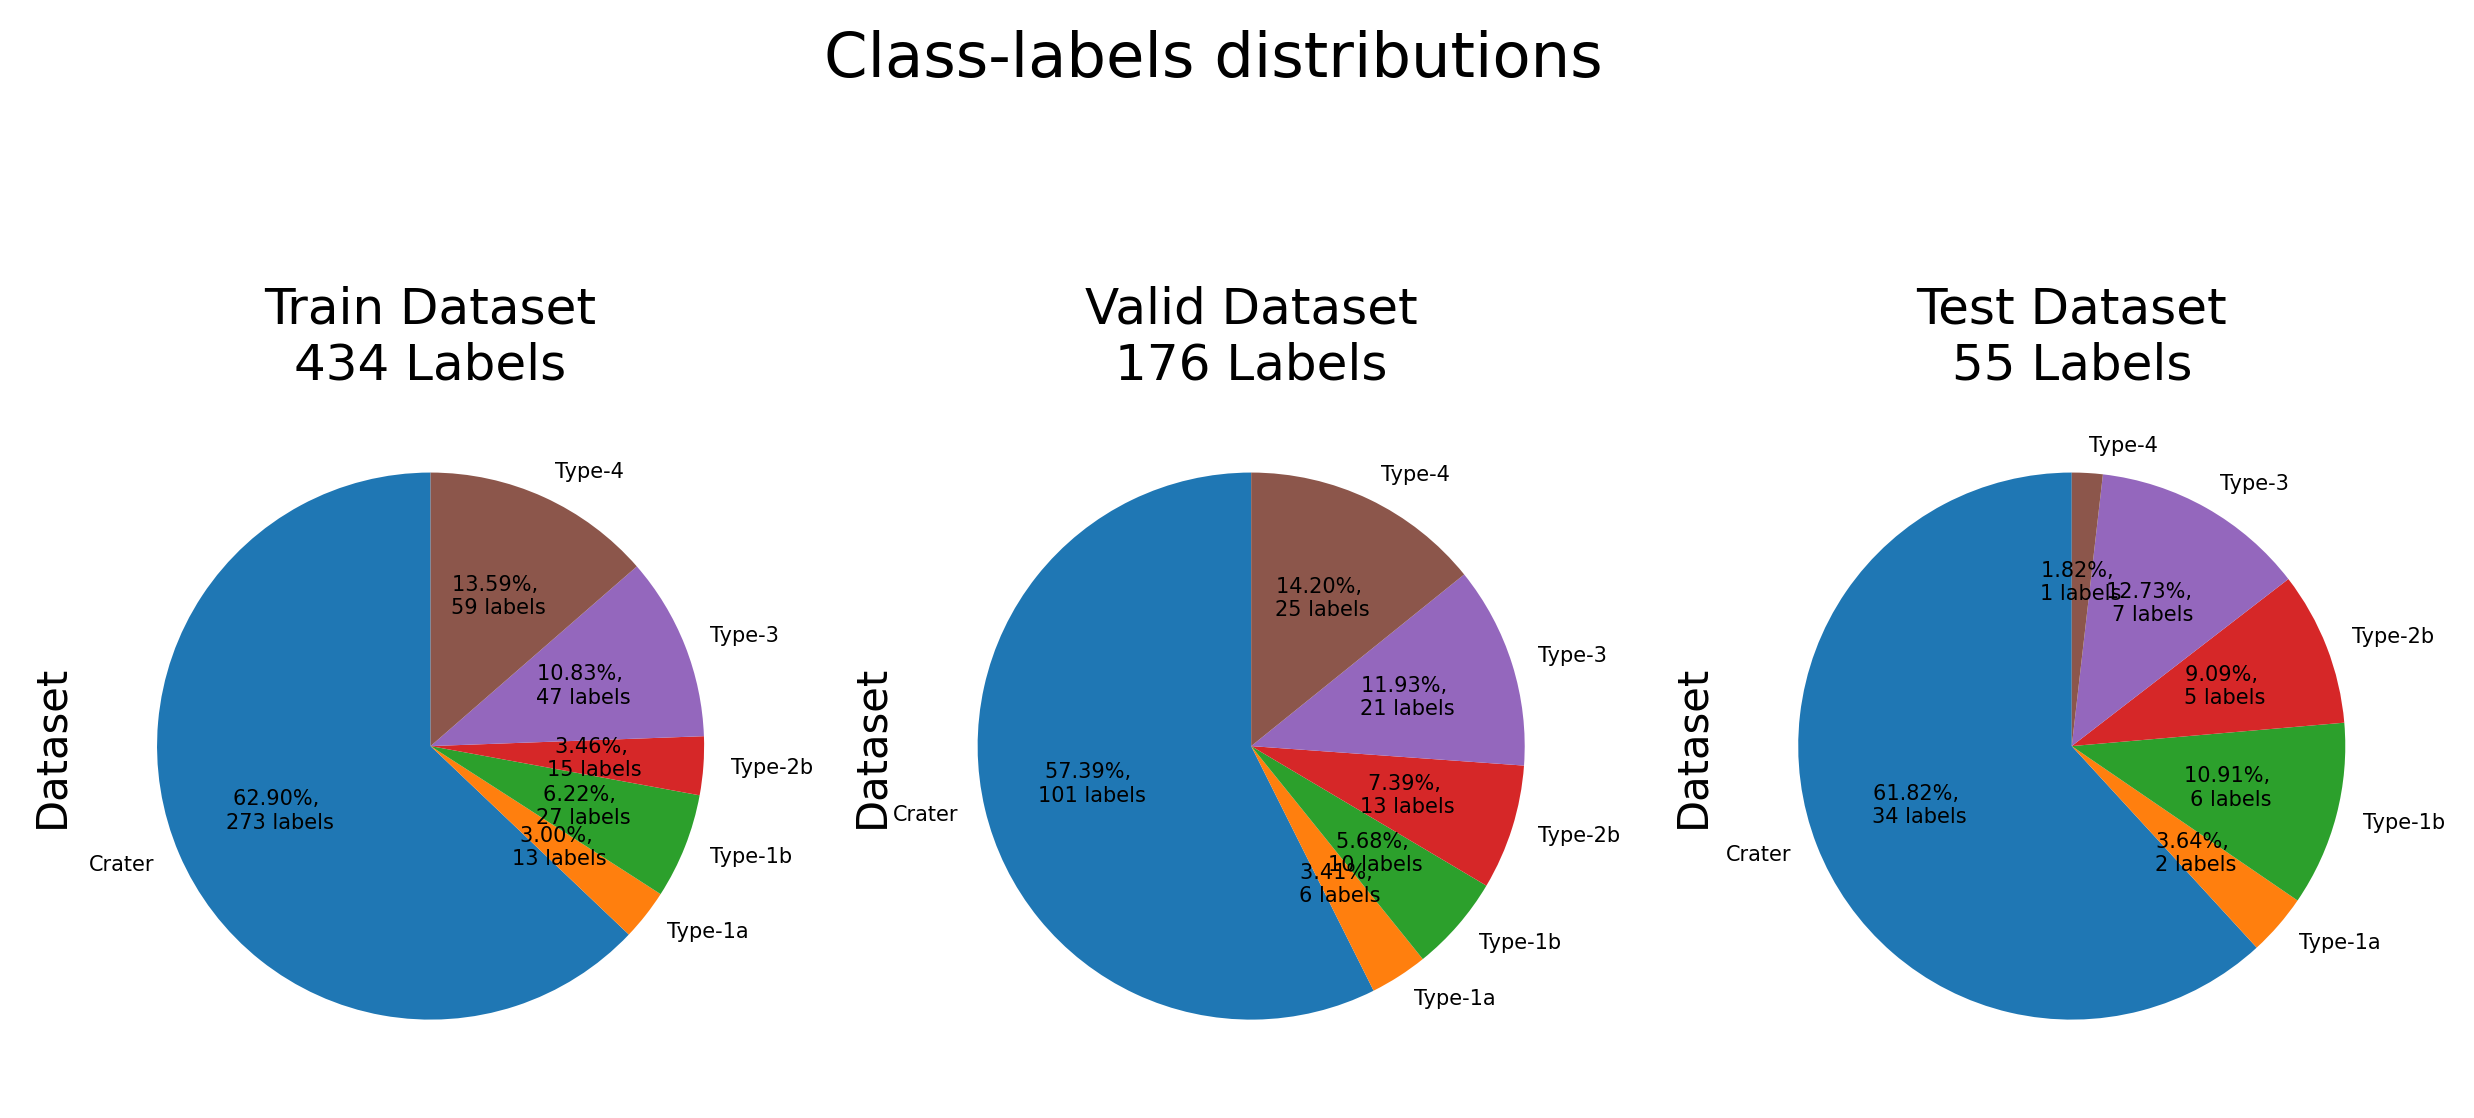

In [6]:
label = classes
plt.figure(figsize = (10,5), facecolor='white',dpi=300)
plt.suptitle('Class-labels distributions', fontsize=15)
ax1 = plt.subplot(131)
train_df_dis.groupby(['Class']).count().plot(kind='pie', figsize=(10,1,0), autopct=lambda p:f'{p:.2f}%, \n{p*len(train_df_dis)/100:.0f} labels',startangle=90, subplots=True, ax =ax1, fontsize=5, legend=False)
plt.title('Train Dataset\n{} Labels'.format(len(train_df_dis), loc='center'))
ax2 = plt.subplot(132)
valid_df_dis.groupby(['Class']).count().plot(kind='pie', figsize=(10,10),autopct=lambda p:f'{p:.2f}%, \n{p*len(valid_df_dis)/100:.0f} labels',startangle=90, subplots=True, ax =ax2, fontsize=5,legend=False)
plt.title('Valid Dataset\n{} Labels'.format(len(valid_df_dis), loc='center', ))
ax3 = plt.subplot(133)
test_df_dis.groupby(['Class']).count().plot(kind='pie', figsize=(10,10),autopct=lambda p:f'{p:.2f}%, \n{p*len(test_df_dis)/100:.0f} labels',startangle=90, subplots=True, ax =ax3, fontsize=5,legend=False)
plt.title('Test Dataset\n{} Labels'.format(len(test_df_dis), loc='center', ))

../data/../data/ESP_055614_1605_RED_H1_V0_cropped_centered_resized.tiff


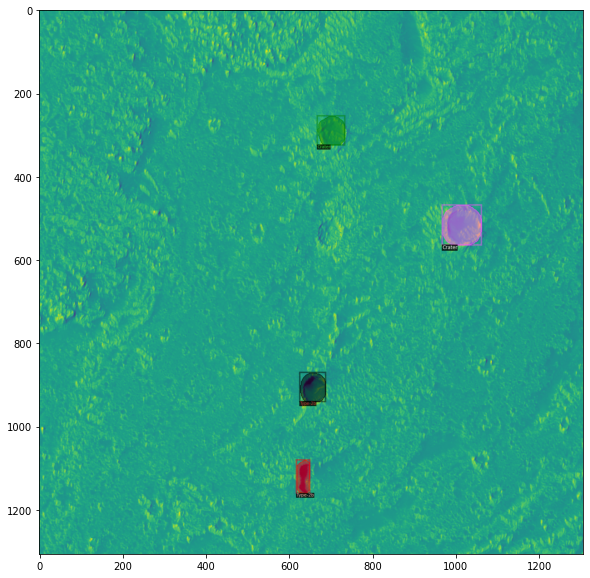

In [7]:
for d in random.sample(train, 1):
    img_path = d["file_name"]
    print(img_path)
    img = cv2.imread(img_path)
    visualizer = Visualizer(img[:, :, 1:-1], metadata=meta, scale=2)
    out = visualizer.draw_dataset_dict(d)
    fig = plt.figure(figsize=(10,10))
    plt.imshow(out.get_image()[:, :, :])

In [8]:
# RUN
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)

[10/12 15:51:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [9]:
trainer.resume_or_load(resume=False)
trainer.train()

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[10/12 15:51:21 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[10/12 15:51:25 d2.utils.events]:  eta: 0:14:03  iter: 19  total_loss: 3.461  loss_cls: 1.809  loss_box_reg: 0.8088  loss_mask: 0.6909  loss_rpn_cls: 0.1024  loss_rpn_loc: 0.02274  time: 0.1648  data_time: 0.0173  lr: 3.9962e-05  max_mem: 1367M
[10/12 15:51:28 d2.utils.events]:  eta: 0:14:24  iter: 39  total_loss: 2.729  loss_cls: 1.094  loss_box_reg: 0.8831  loss_mask: 0.6569  loss_rpn_cls: 0.03584  loss_rpn_loc: 0.03166  time: 0.1618  data_time: 0.0017  lr: 7.9922e-05  max_mem: 1488M
[10/12 15:51:32 d2.utils.events]:  eta: 0:14:29  iter: 59  total_loss: 1.984  loss_cls: 0.6296  loss_box_reg: 0.6595  loss_mask: 0.6077  loss_rpn_cls: 0.02795  loss_rpn_loc: 0.02796  time: 0.1695  data_time: 0.0014  lr: 0.00011988  max_mem: 1618M
[10/12 15:51:36 d2.utils.events]:  eta: 0:14:26  iter: 79  total_loss: 2.019  loss_cls: 0.5936  loss_box_reg: 0.768  loss_mask: 0.5073  loss_rpn_cls: 0.0384  loss_rpn_loc: 0.03313  time: 0.1726  data_time: 0.0015  lr: 0.00015984  max_mem: 1618M
[10/12 15:51:39 d

KeyboardInterrupt: 

Process Process-8:
Process Process-4:
Process Process-3:
Process Process-7:
Process Process-6:
Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 318, in _bootstrap
    util._ex